In [1]:
import sys
sys.path.append('./')
import genomic_position_utils as gp
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)

cat_type = pd.CategoricalDtype(categories=['I', 'II', 'III', 'IV', 'V', 'X'], ordered=True)
res['chromosome'] = res.chromosome.astype(cat_type)

# Genomic Location

In [3]:
AND = (res['padj-58'] < 0.05) & (res['padj-50'] < 0.05) & (res['Sign-WT'] == 'Same')
OR = (res['padj-58'] < 0.05) & (res['padj-50'] < 0.05) & (res['Sign-WT'] == 'Same')

print('DE genes at 58hrs', AND.sum())
# cols = ','.split('Chromosome,No. Genes in Chromosome,Observed,Bonferroni Adjusted P-value')
chrom_enrich = []
for n, g in res.groupby('chromosome'):
    Total = len(res)
    Chrom = len(g)
    draws = AND.sum()  # total number of DEGs considered
    obs = (AND & (res.chromosome == n)).sum()  # number of DEGS seen in THIS chromosome
    pval = scipy.stats.hypergeom.sf(obs, Total, Chrom, draws)
    chrom_enrich += [[n, Chrom, obs, '{0:.2g}'.format(np.min([pval * res.chromosome.nunique(), 1]))]]

chrom_enrich = pd.DataFrame(chrom_enrich,
                            columns=['Chromosome', 'Genes in Chromosome', 'DEGs in Chromosome', 'pval'])
chrom_enrich.pval = chrom_enrich.pval.astype(np.float)
sig_chromosomes = chrom_enrich[chrom_enrich.pval < 10 ** -2].Chromosome.values
chrom_enrich[chrom_enrich.pval < 10 ** -2].head()

DE genes at 58hrs 650


,Chromosome,Genes in Chromosome,DEGs in Chromosome,pval
3,IV,2015,145,0.00018


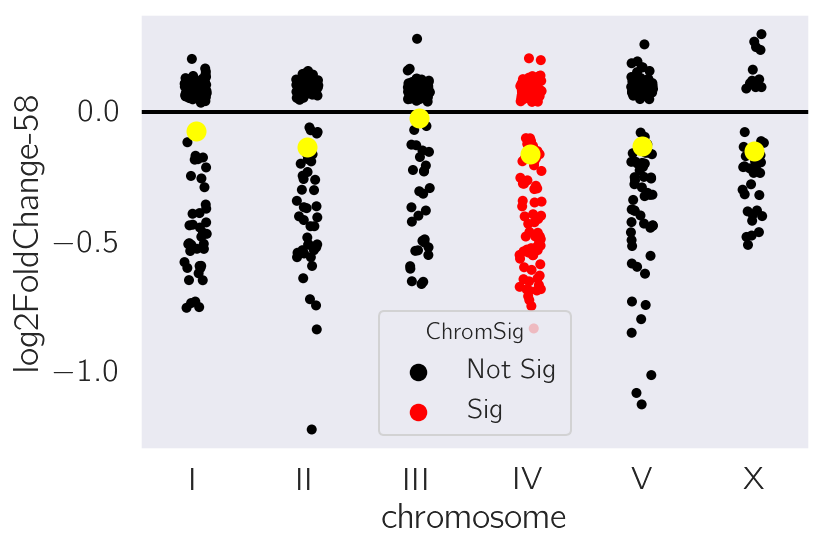

In [4]:
def save(x):
    plt.savefig('../figs/' + x, bbox_inches='tight')

res['ChromSig'] = res.chromosome.map({c: ('Not Sig' if c not in sig_chromosomes else 'Sig') for c in res.chromosome.unique()})
sns.stripplot(x='chromosome', y='log2FoldChange-58', data=res[AND],
              hue='ChromSig', palette=['black', 'red'], hue_order=['Not Sig', 'Sig'])
sns.stripplot(x='chromosome', y='log2FoldChange-58', data=res[AND].groupby('chromosome')['log2FoldChange-58'].apply(np.mean).reset_index(),
             size=10, color='yellow', jitter=False)
plt.axhline(0, color='black')
save('chrom_expression.pdf')

In [5]:
stat = np.median

def bootstrap(stat=np.median):
    new = res.sample(n=AND.sum(), replace=False).copy()
    new['Diff'] = np.log10(new.sort_values(['chromosome', 'startposition']
                                          ).groupby('chromosome').startposition.diff() + 1)
    return new.groupby('chromosome').Diff.median().reset_index()

boots = []
for i in range(10 ** 4):
    if i % 10 **3 == 0:
        print('Bootstrap', i, 'finished')
    boots += [bootstrap()]

boots = pd.concat(boots)

Bootstrap 0 finished
Bootstrap 1000 finished
Bootstrap 2000 finished
Bootstrap 3000 finished
Bootstrap 4000 finished
Bootstrap 5000 finished
Bootstrap 6000 finished
Bootstrap 7000 finished
Bootstrap 8000 finished
Bootstrap 9000 finished


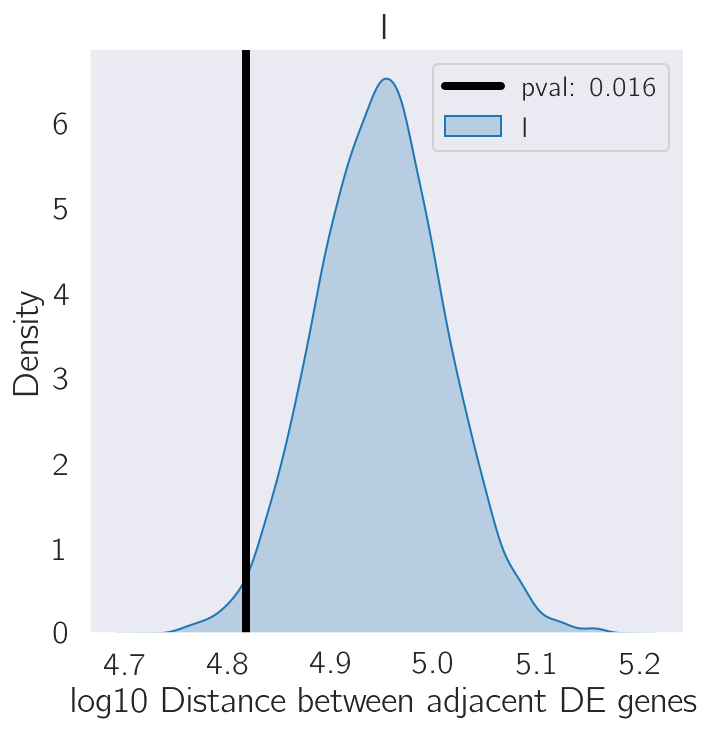

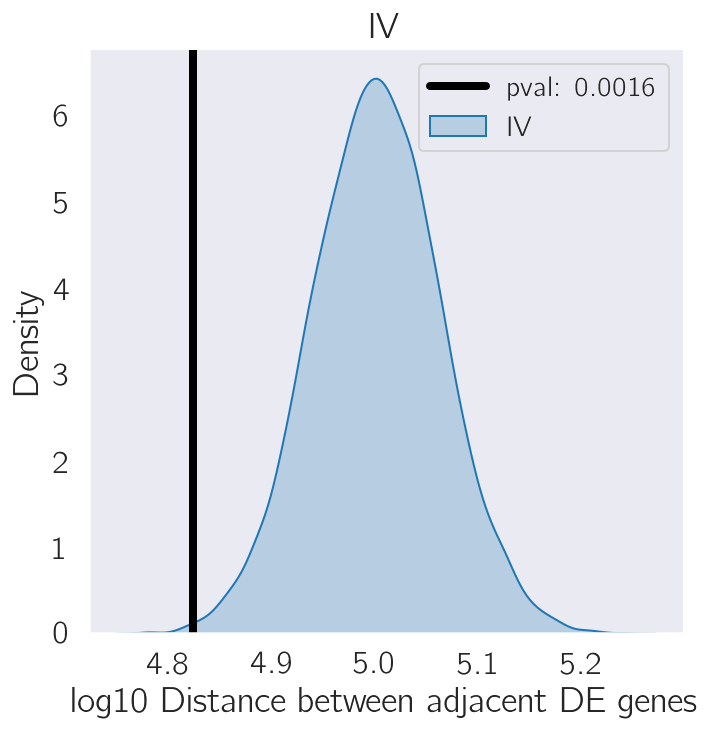

In [6]:
tmp = res[AND].copy()
tmp['Diff'] = np.log10(tmp.sort_values(['chromosome', 'startposition']).groupby('chromosome').startposition.diff() + 1)

for n, g in boots.groupby('chromosome'):
    obs = tmp[(tmp.chromosome == n)].Diff.median()
    pval = (g.Diff < obs).sum() / len(g)
    alpha = 0.05  # bonferroni correction

    if pval > alpha:
        continue

    sns.displot(g.Diff, label=n, kind='kde', fill=True)
    plt.axvline(obs, label='pval: {0:.2g}'.format(pval), lw=4, color='black')
    plt.legend()
    plt.xlabel('log10 Distance between adjacent DE genes')
    plt.title(n)

In [7]:
corr, shuffled = gp.get_corr_and_shuffle(res, x='50', pval = 0.05, window=20)

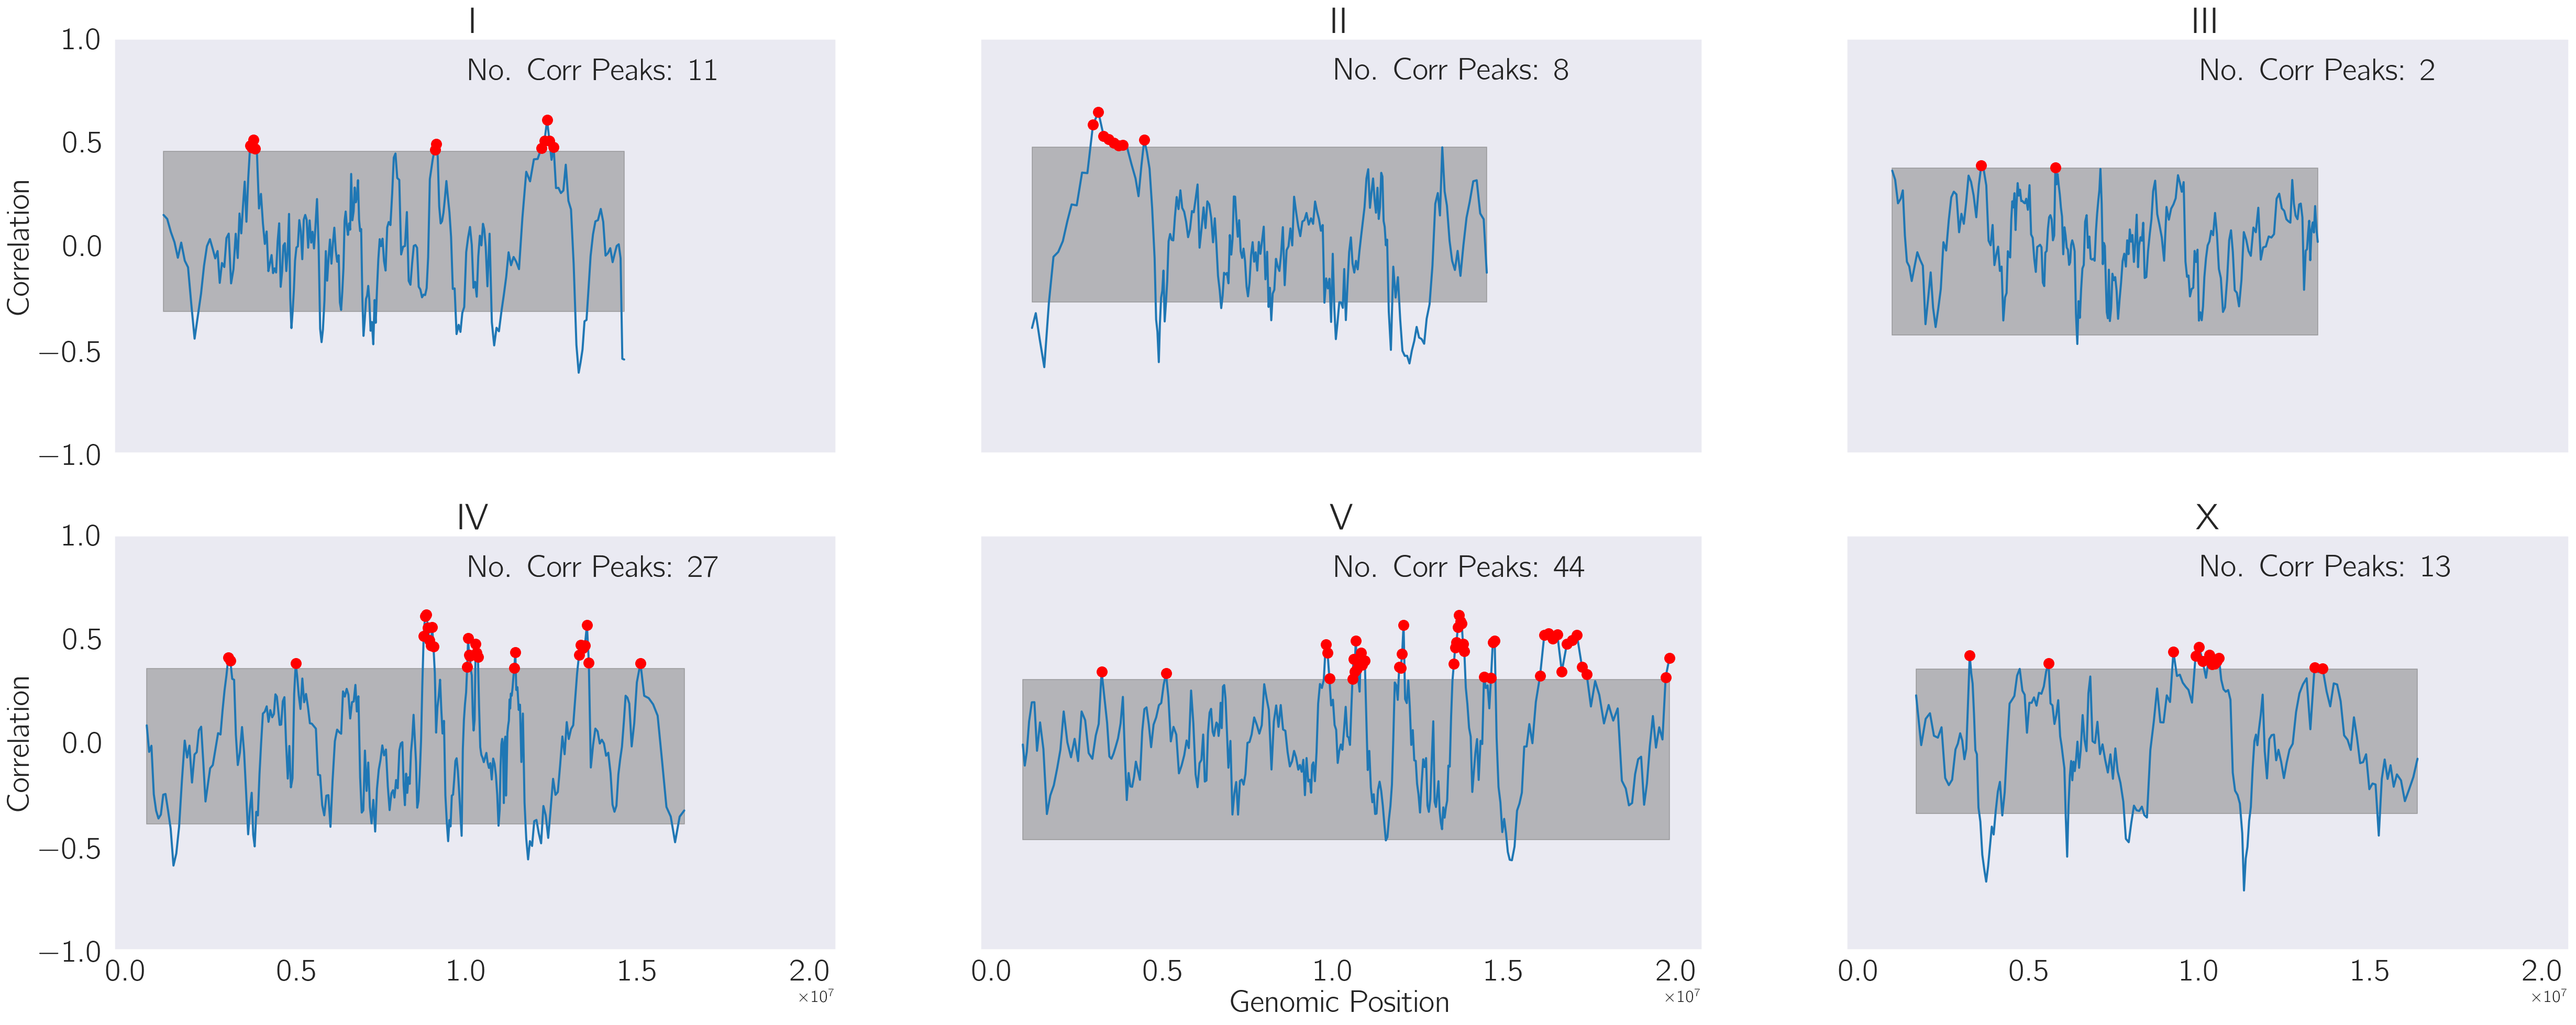

In [8]:
fig, ax = gp.plot_corrs(corr, shuffled)
plt.ylim(-1, 1)
save('chromosome_location_sliding_window_at_50hrs.pdf')

In [9]:
corr, shuffled = gp.get_corr_and_shuffle(res, '58', 0.05, window=20)

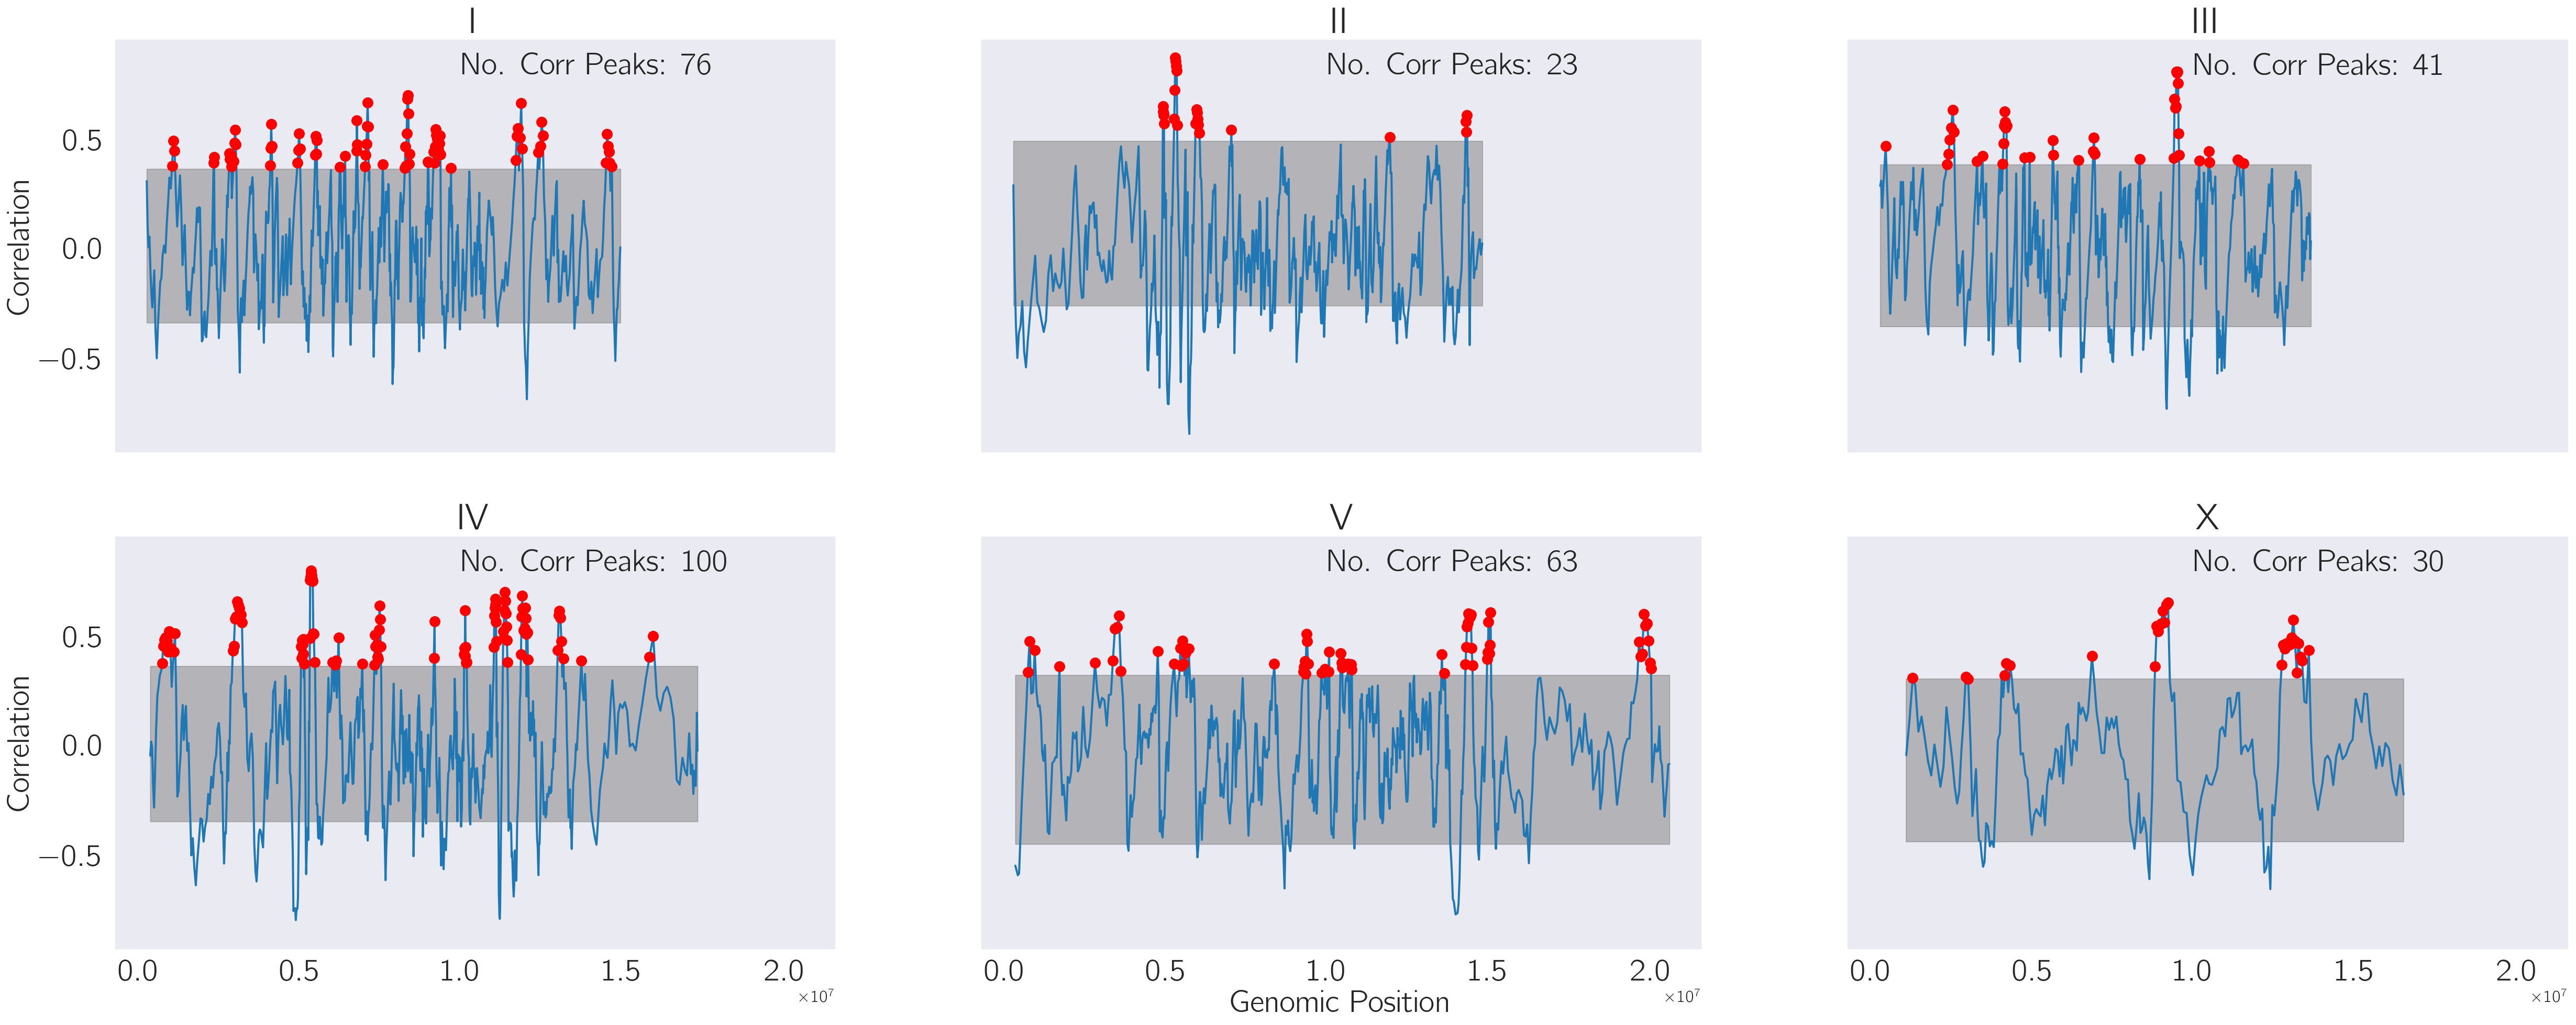

In [10]:
fig, ax = gp.plot_corrs(corr, shuffled)
save('chromosome_location_sliding_window_at_58hrs.pdf')

In [ ]:
corr, shuffled = gp.get_corr_and_shuffle(res, 'pqm1', 0.05, window=20)

In [ ]:
fig, ax = gp.plot_corrs(corr, shuffled)
save('chromosome_location_sliding_window_at_pqm1_50hrs.pdf')

# PQM-1 Enrichment

In [ ]:
message, antimessage, params = gp.calculate_enrichment()
print('Enrichment of PQM-1 targets in commonly DE genes across 50 and 58hrs:')
print(message.format(*params))
print('Depletion of PQM-1 targets in commonly DE genes across 50 and 58hrs:')
print(antimessage.format(*params))

In [ ]:
def test_enrichment_by_direction(test='pqm1', whale=False):
    for i in ['50', '58']:
        for j in ['DOWN', 'UP']:
            if j == 'UP':
                direction = (res['log2FoldChange-' + i] > 0)
            else:
                direction = (res['log2FoldChange-' + i] < 0)
            
            if whale == True:
                direction = direction & (res.Above)
            
            message, antimessage, params = gp.calculate_enrichment((res['padj-' + i] < 0.05) & direction, alpha=0.01, suppress=True, test=test)
            if params[-3] < 0.05:
                print('Enrichment test for {0}-regulated genes at {1}hrs'.format(j, i))
                print(message.format(*params))
                print('#################################################\n')
            elif params[-1] < 0.05:
                print('DEPLETION test for {0}-regulated genes at {1}hrs'.format(j, i))
                print(antimessage.format(*params))
                print('#################################################\n')
            
test_enrichment_by_direction()

# DAF-16 enrichment

In [ ]:
message, antimessage, params = calculate_enrichment(test='daf16')
print('Enrichment')
print(message.format(*params))
print('Depletion:')
print(antimessage.format(*params))

In [ ]:
test_enrichment_by_direction(test='daf16')